In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import RandomErasing
from fastervit.models.faster_vit import FasterViT  # Import FasterViT
from fastervit import create_model  # Import create_model function
import os




In [51]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    # Define the device as the first visible cuda device if available
    device = torch.device("cuda:0")
    print(f"Running on {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Running on CPU")


Running on NVIDIA GeForce RTX 3080


In [52]:
# Data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])


In [53]:
train_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/train"
val_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/validation"
test_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/test" 

# Data loaders
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, generator=torch.Generator(device='cuda'))

val_dataset = datasets.ImageFolder(val_dataset_path, transform=train_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)

test_dataset = datasets.ImageFolder(test_dataset_path, transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

In [54]:
# Create a directory for storing model weights
model_dir = "C:/Users/Henry/Downloads/fastervit_0_224_1k.pth.tar"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "faster_vit_0.pth.tar")

# Define and create the FasterViT model
model_name = 'faster_vit_0_224'  # Model name as per the fastervit documentation
model = create_model(model_name, 
                     pretrained=True,
                     model_path=model_path)

num_classes = 2
in_features = model.head.in_features
model.head = torch.nn.Linear(in_features, num_classes)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

In [55]:
# Loss and Optimizer with L2 Regularization (Weight Decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

In [56]:
# Training Loop
num_epochs = 1
for epoch in range(num_epochs):  
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Save the model at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, f"model_epoch_{epoch+1}.pth")

Epoch [1/1], Step [100/4376], Loss: 0.2621
Epoch [1/1], Step [200/4376], Loss: 0.1447
Epoch [1/1], Step [300/4376], Loss: 0.1384
Epoch [1/1], Step [400/4376], Loss: 0.1897
Epoch [1/1], Step [500/4376], Loss: 0.0569
Epoch [1/1], Step [600/4376], Loss: 0.0158
Epoch [1/1], Step [700/4376], Loss: 0.1689
Epoch [1/1], Step [800/4376], Loss: 0.1486
Epoch [1/1], Step [900/4376], Loss: 0.1116
Epoch [1/1], Step [1000/4376], Loss: 0.0791
Epoch [1/1], Step [1100/4376], Loss: 0.3225
Epoch [1/1], Step [1200/4376], Loss: 0.1551
Epoch [1/1], Step [1300/4376], Loss: 0.1606
Epoch [1/1], Step [1400/4376], Loss: 0.1142
Epoch [1/1], Step [1500/4376], Loss: 0.0423
Epoch [1/1], Step [1600/4376], Loss: 0.1165
Epoch [1/1], Step [1700/4376], Loss: 0.0957
Epoch [1/1], Step [1800/4376], Loss: 0.0896
Epoch [1/1], Step [1900/4376], Loss: 0.1822
Epoch [1/1], Step [2000/4376], Loss: 0.0673
Epoch [1/1], Step [2100/4376], Loss: 0.0988
Epoch [1/1], Step [2200/4376], Loss: 0.0800
Epoch [1/1], Step [2300/4376], Loss: 0.09

In [57]:
best_val_accuracy = 0
# Validation Loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    current_val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {100 * correct / total}%")
    # Save the model if it has the best validation accuracy so far
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        torch.save(model.state_dict(), 'best_model_val_accuracy.pth')

Validation Accuracy: 95.07710256670387%


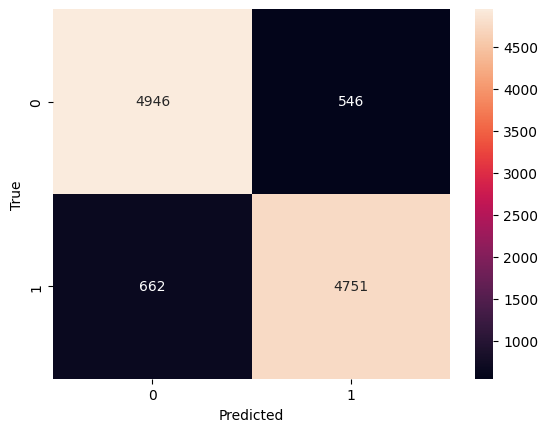

Test Accuracy: 88.922512608895%


In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test Loop with Confusion Matrix
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate and print test accuracy
correct = sum([1 for i, j in zip(all_labels, all_preds) if i == j])
total = len(all_labels)
print(f"Test Accuracy: {100 * correct / total}%")
torch.save(model.state_dict(), 'model_after_test.pth')
